In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pickle
import gzip
import h5py
import sklearn
import sklearn.datasets
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline

import sys
sys.path.append("../")
from src.scalers import *
from src.metrics import *

### Load data

In [2]:
dataset = pd.DataFrame(pd.read_csv('../input/digit-recognizer/train.csv'))
dataset = np.array(dataset, dtype='float64')
X, y = dataset[:, 1:], dataset[:, 0, np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [3]:
def preprocess_data(X, y):
    yy = np.zeros(shape=[10, y.shape[0]])
    for i in range(y.shape[0]):
        yy[int(y[i]), i] = 1.
    return X.T, yy

In [4]:
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [5]:
pd.DataFrame(y_train)

,0,1,2,3,4,5,6,7,8,9,...,37790,37791,37792,37793,37794,37795,37796,37797,37798,37799
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## Feedforward

* ***Activation function (sigmoid)***

In [6]:
def sigmoid(Z):
    
    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples 
    # sigmoid_memory is stored as it is used later on in backpropagation
    
    H = 1 / (1 + np.exp(-Z))
    sigmoid_memory = Z
    
    return H, sigmoid_memory

* ***Activation function (ReLU)***

In [7]:
def relu(Z):
    
    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples 
    # relu_memory is stored as it is used later on in backpropagation
    
    H = np.maximum(0, Z)
    
    assert(H.shape == Z.shape)
    
    relu_memory = Z
    return H, relu_memory

* ***Activation function (softmax)***

In [8]:
def softmax(Z):
    
    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples 
    # softmax_memory is stored as it is used later on in backpropagation
   
    Z_exp = np.exp(Z)

    Z_sum = np.sum(Z_exp, axis=0, keepdims=True)
    
    H = Z_exp / Z_sum  # normalising step
    softmax_memory = Z
    
    return H, softmax_memory

### Initialize parameters

The inputs to this function is a list named dimensions.
The length of the list is the number layers in the network + 1 (the plus one is for the input layer, rest are hidden + output).
The first element of this list is the dimensionality or length of the input (784 for the MNIST dataset).
The rest of the list contains the number of neurons in the corresponding (hidden and output) layers.

For example dimensions = [784, 3, 7, 10] specifies a network for the MNIST dataset with two hidden layers and a 10-dimensional softmax output.

Parameters are returned in a dictionary.
This will help you in implementing the feedforward through the layer and the backprop throught the layer at once.

In [9]:
def initialize_parameters(dimensions):

    # dimensions is a list containing the number of neuron in each layer in the network
    # It returns parameters which is a python dictionary containing the parameters "W1", "b1", ..., "WL", "bL":

    np.random.seed(2)
    parameters = {}
    L = len(dimensions)            # number of layers in the network + 1

    for l in range(1, L): 
        parameters['W' + str(l)] = np.random.randn(dimensions[l], dimensions[l-1]) * 0.1
        parameters['b' + str(l)] = np.zeros((dimensions[l], 1)) 
        
        assert(parameters['W' + str(l)].shape == (dimensions[l], dimensions[l-1]))
        assert(parameters['b' + str(l)].shape == (dimensions[l], 1))
 
    return parameters

### Layer forward

layer_forward implements the forward propagation for a certain layer.
It calculates the cumulative input into the layer Z and uses it to calculate the output of the layer H.
It takes H_prev, W, b and the activation function as inputs and stores the linear_memory, activation_memory in the variable memory which will be used later in backpropagation.


You have to first calculate the Z(using the forward propagation equation), linear_memory(H_prev, W, b) and then calculate H, activation_memory(Z) by applying activation functions - sigmoid, relu and softmax on Z.


Note that$$H^{L-1}$$is referred here as H_prev.

In [11]:
def layer_forward(H_prev, W, b, activation = 'relu'):

    # H_prev is of shape (size of previous layer, number of examples)
    # W is weights matrix of shape (size of current layer, size of previous layer)
    # b is bias vector of shape (size of the current layer, 1)
    # activation is the activation to be used for forward propagation : "softmax", "relu", "sigmoid"

    # H is the output of the activation function 
    # memory is a python dictionary containing "linear_memory" and "activation_memory"
    
    if activation == "sigmoid":
        Z = np.add(np.dot(W, H_prev), b)
        linear_memory = (H_prev, W, b)
        H, activation_memory = sigmoid(Z)
 
    elif activation == "softmax":
        Z = np.add(np.dot(W, H_prev), b)
        linear_memory = (H_prev, W, b)
        H, activation_memory = softmax(Z)
    
    elif activation == "relu":
        Z = np.add(np.dot(W, H_prev) ,b)
        linear_memory = (H_prev, W, b)
        H, activation_memory = relu(Z)
        
    assert (H.shape == (W.shape[0], H_prev.shape[1]))
    memory = (linear_memory, activation_memory)

    return H, memory

### L layer forward

L_layer_forward performs one forward pass through the whole network for all the training samples (in one single batch). 
Use the layer_forward you have created above here to perform the feedforward for layers 1 to 'L-1' in the for loop with the activation relu. 
The last layer having a different activation softmax is calculated outside the loop. 
Notice that the memory is appended to memories for all the layers. These will be used in the backward order during backpropagation.

In [12]:
def L_layer_forward(X, parameters):

    # X is input data of shape (input size, number of examples)
    # parameters is output of initialize_parameters()
    
    # HL is the last layer's post-activation value
    # memories is the list of memory containing (for a relu activation, for example):
    # - every memory of relu forward (there are L-1 of them, indexed from 1 to L-1), 
    # - the memory of softmax forward (there is one, indexed L) 

    memories = []
    H = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement relu layer (L-1) times as the Lth layer is the softmax layer
    for l in range(1, L):
        H_prev = H #write your code here 
        
        H, memory = layer_forward(H_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation="relu")
        
        memories.append(memory)
    
    # Implement the final softmax layer
    # HL here is the final prediction P as specified in the lectures
    HL, memory = layer_forward(H, parameters['W' + str(l+1)], parameters['b' + str(l+1)], activation="softmax")
    
    memories.append(memory)

    assert(HL.shape == (10, X.shape[1]))
            
    return HL, memories

## Loss

compute_loss here calculates the cross-entropy loss.
It is the average loss across all the data points in the batch.
It takes the output of the last layer HL and the ground truth label Y as input and returns the loss.

In [13]:
def compute_loss(HL, Y):

    # HL is probability matrix of shape (10, number of examples)
    # Y is true "label" vector shape (10, number of examples)

    # loss is the cross-entropy loss

    m = Y.shape[1]

    loss = -1. / m * np.sum(np.multiply(Y, np.log(HL)))
    
    loss = np.squeeze(loss)      # To make sure that the loss's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(loss.shape == ())
    
    return loss

## Backpropagation

* ***Sigmoid backward***

In [14]:
def sigmoid_backward(dH, sigmoid_memory):
    
    # Implement the backpropagation of a sigmoid function
    # dH is gradient of the sigmoid activated activation of shape same as H or Z in the same layer    
    # sigmoid_memory is the memory stored in the sigmoid(Z) calculation
    
    Z = sigmoid_memory
    
    H = 1 / (1 + np.exp(-Z))
    dZ = dH * H * (1 - H)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

* ***ReLU backward***

In [15]:
def relu_backward(dH, relu_memory):
    
    # Implement the backpropagation of a relu function
    # dH is gradient of the relu activated activation of shape same as H or Z in the same layer    
    # relu_memory is the memory stored in the sigmoid(Z) calculation
    
    Z = relu_memory
    dZ = np.array(dH, copy=True) # dZ will be the same as dA wherever the elements of A weren't 0
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### Layer backward

In [16]:
def layer_backward(dH, memory, activation = 'relu'):
    
    # takes dH and the memory calculated in layer_forward and activation as input to calculate the dH_prev, dW, db
    # performs the backprop depending upon the activation function
    

    linear_memory, activation_memory = memory
    
    if activation == "relu":
        dZ = relu_backward(dH, activation_memory)
        H_prev, W, b = linear_memory
        m = H_prev.shape[1]
        dW = np.dot(dZ, H_prev.T) * (1. / m)
        db = np.sum(dZ * (1. / m), axis=1).reshape((activation_memory.shape[0], 1))
        dH_prev = np.dot(W.T, dZ)
        
    elif activation == "sigmoid":
        dZ = relu_sigmoid(dH, activation_memory)
        H_prev, W, b = linear_memory
        m = H_prev.shape[1]
        dW = np.dot(dZ, H_prev.T)*(1. / m)
        db =  np.sum(dZ * (1. / m), axis=1).reshape((activation_memory.shape[0], 1))
        dH_prev = np.dot(W.T, dZ)
    
    return dH_prev, dW, db

### L layer backward

In [17]:
def L_layer_backward(HL, Y, memories):
    
    # Takes the predicted value HL and the true target value Y and the 
    # memories calculated by L_layer_forward as input
    
    # returns the gradients calulated for all the layers as a dict

    gradients = {}
    L = len(memories) # the number of layers
    m = HL.shape[1]
    Y = Y.reshape(HL.shape) # after this line, Y is the same shape as AL
    
    # Perform the backprop for the last layer that is the softmax layer
    current_memory = memories[-1]
    linear_memory, activation_memory = current_memory
    dZ = HL - Y
    H_prev, W, b = linear_memory
    # Use the expressions you have used in 'layer_backward'
    gradients["dH" + str(L - 1)] = np.dot(W.T, dZ)
    gradients["dW" + str(L)] =  np.dot(dZ, H_prev.T) * (1. / m)
    gradients["db" + str(L)] = np.sum(dZ * (1. / m), axis=1).reshape((activation_memory.shape[0], 1))
    
    # Perform the backpropagation l-1 times
    for l in reversed(range(L - 1)):
        # Lth layer gradients: "gradients["dH" + str(l + 1)] ", gradients["dW" + str(l + 2)] , gradients["db" + str(l + 2)]
        current_memory = memories[l]
        
        dH_prev_temp, dW_temp, db_temp = layer_backward(gradients["dH" + str(l + 1)], current_memory, activation = 'relu')
        gradients["dH" + str(l)] = dH_prev_temp
        gradients["dW" + str(l + 1)] = dW_temp
        gradients["db" + str(l + 1)] = db_temp


    return gradients

## Parameter updates

In [18]:
def update_parameters(parameters, gradients, learning_rate):

    # parameters is the python dictionary containing the parameters W and b for all the layers
    # gradients is the python dictionary containing your gradients, output of L_model_backward
    
    # returns updated weights after applying the gradient descent update

    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):

        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - (learning_rate* gradients["dW" + str(l + 1)])
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - (learning_rate* gradients["db" + str(l + 1)])

        
    return parameters

In [19]:
dimensions = [784, 45, 10]  # three-layer model

## Model

### L layer model

In [20]:
def L_layer_model(X, Y, dimensions, learning_rate = 0.0075, num_iterations = 3000, print_loss=False):
    
    # X and Y are the input training datasets
    # learning_rate, num_iterations are gradient descent optimization parameters
    # returns updated parameters

    np.random.seed(2)
    losses = []  # keep track of loss
    
    # Parameters initialization
    parameters = initialize_parameters(dimensions)
 
    for i in range(0, num_iterations):

        # Forward propagation
        HL, memories = L_layer_forward(X, parameters)
        
        # Compute loss
        loss = compute_loss(HL, Y)
    
        # Backward propagation
        gradients = L_layer_backward(HL, Y, memories)
 
        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)
                
        # Printing the loss every 100 training example
        if print_loss and i % 100 == 0:
            print ("Loss after iteration %i: %f" %(i, loss))
            losses.append(loss)
            
    # Plotting the loss
    plt.plot(np.squeeze(losses))
    plt.ylabel('loss')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


Loss after iteration 0: nan
Loss after iteration 100: nan
Loss after iteration 200: nan
Loss after iteration 300: nan
Loss after iteration 400: nan
Loss after iteration 500: nan
Loss after iteration 600: nan
Loss after iteration 700: nan
Loss after iteration 800: nan
Loss after iteration 900: nan
Loss after iteration 1000: nan
Loss after iteration 1100: nan
Loss after iteration 1200: nan
Loss after iteration 1300: nan
Loss after iteration 1400: nan
Loss after iteration 1500: nan
Loss after iteration 1600: nan
Loss after iteration 1700: nan
Loss after iteration 1800: nan
Loss after iteration 1900: nan


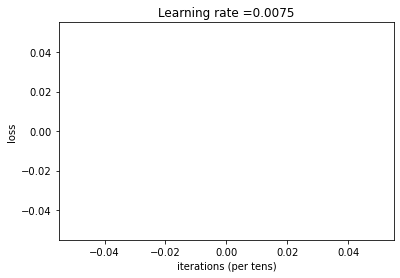

In [22]:
parameters = L_layer_model(x_train, y_train, dimensions, num_iterations = 2000, print_loss = True)

In [23]:
def predict(X, y, parameters):
    
    # Performs forward propogation using the trained parameters and calculates the accuracy
    
    m = X.shape[1]
    n = len(parameters) // 2  # number of layers in the neural network
    
    # Forward propagation
    probas, caches = L_layer_forward(X, parameters)
    
    p = np.argmax(probas, axis = 0)
    act = np.argmax(y, axis = 0)

    print("Accuracy: "  + str(np.sum((p == act)/m)))
        
    return p

In [24]:
pred_test = predict(x_test, y_test, parameters)

Accuracy: 0.09714285714285714
